In [1]:
!pip3 install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 92.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # WLS license
# params = {

# }

# # data path
# file_path = ''

In [40]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import random
import math
import sys

env = gp.Env(params=params)
pd.set_option('display.max_columns', None)

def dist(x1, y1, x2, y2):
    return np.abs(x1 - x2) + np.abs(y1 - y2)

def solve_model(w, c, R, beta, N_RESTAURANTS, N_CUSTOMERS, tau, LAMBDA, MU_P, V_MAX, RELOCATION_K, MAX_BATCH, verbose = 0):

    model = gp.Model(env = env)
    model.setParam("NonConvex", 2)
    model.setParam('MIPGap', 1e-2)

    # FLOW VARIABLES
    lam_f_rcb = model.addMVar((N_RESTAURANTS, N_CUSTOMERS, MAX_BATCH), lb = 0, ub = LAMBDA, vtype = GRB.CONTINUOUS, name = "lam_f_rcb")
    lam_p_rcb = model.addMVar((N_RESTAURANTS, N_CUSTOMERS, MAX_BATCH), lb = 0, ub = LAMBDA, vtype = GRB.CONTINUOUS, name = "lam_p_rcb")

    # the customer-restaurant flow is upper bounded by the total order rate from all restaurants to the customer
    lam_f_cr = model.addMVar((N_CUSTOMERS, N_RESTAURANTS), lb = 0, ub = np.tile(np.sum(LAMBDA, axis = (0, 2)), (N_RESTAURANTS, 1)).T, vtype = GRB.CONTINUOUS, name = "lam_f_cr")
    lam_p_cr = model.addMVar((N_CUSTOMERS, N_RESTAURANTS), lb = 0, ub = np.tile(np.sum(LAMBDA, axis = (0, 2)), (N_RESTAURANTS, 1)).T, vtype = GRB.CONTINUOUS, name = "lam_p_cr")

    mu_p_in  = model.addMVar(N_RESTAURANTS, lb = 0, ub = MU_P, vtype = GRB.CONTINUOUS, name = "mu_p_in")
    mu_p_out = model.addMVar(N_CUSTOMERS,   lb = 0, ub = MU_P, vtype = GRB.CONTINUOUS, name = "mu_p_out")

    # VALUES
    V_r = model.addMVar(N_RESTAURANTS, lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_r")
    V_c = model.addMVar(N_CUSTOMERS,   lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_c")
    V_bar = model.addVar(lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_bar")

    # AUXILIARY VARIABLE FOR TOTAL COST OF PART-TIME
    T = model.addVar(lb = 0, ub = np.sum(2 * tau * LAMBDA * w), vtype = GRB.CONTINUOUS, name = "T")

    # Flow balance constraints
    for i in range(N_RESTAURANTS):
        model.addConstr(mu_p_in[i] + gp.quicksum(lam_p_cr[j, i] for j in range(N_CUSTOMERS)) == gp.quicksum(lam_p_rcb[i, j, b] for j in range(N_CUSTOMERS) for b in range(MAX_BATCH)))
        model.addConstr(gp.quicksum(lam_f_cr[j, i] for j in range(N_CUSTOMERS)) == gp.quicksum(lam_f_rcb[i, j, b] for j in range(N_CUSTOMERS) for b in range(MAX_BATCH)))

    for j in range(N_CUSTOMERS):
        model.addConstr(gp.quicksum(lam_p_rcb[i, j, b] for i in range(N_RESTAURANTS) for b in range(MAX_BATCH)) == gp.quicksum(lam_p_cr[j, i] for i in range(N_RESTAURANTS)) + mu_p_out[j])
        model.addConstr(gp.quicksum(lam_f_rcb[i, j, b] for i in range(N_RESTAURANTS) for b in range(MAX_BATCH)) == gp.quicksum(lam_f_cr[j, i] for i in range(N_RESTAURANTS)))

    for i in range(N_RESTAURANTS):
      for j in range(N_CUSTOMERS):
        for b in range(MAX_BATCH):
            if LAMBDA[i,j,b] > 0:
              model.addConstr(lam_f_rcb[i, j, b] + lam_p_rcb[i, j, b] == LAMBDA[i, j, b])
            else:
              model.addConstr(lam_f_rcb[i, j, b] == 0)
              model.addConstr(lam_p_rcb[i, j, b] == 0)

    model.addConstr(MU_P >= gp.quicksum(mu_p_in[i] for i in range(N_RESTAURANTS)))

    # IC and IR constraints
    for i in range(N_RESTAURANTS):
        model.addConstr(V_bar >= V_r[i])
        model.addConstr(mu_p_in[i] * (V_bar - V_r[i]) == 0)

    for j in range(N_CUSTOMERS):
        model.addConstr(mu_p_out[j] * (V_c[j] - R) == 0)

    for j in range(N_CUSTOMERS):
      relocation_restaurants = np.argsort(tau[:,j,0])[:RELOCATION_K]
      for i in range(N_RESTAURANTS):
            model.addConstr(V_r[i] + c * tau[i, j, 0] - beta ** tau[i, j, 0] * V_c[j] >= 0)
            if i in relocation_restaurants:
              model.addConstr(V_c[j] + c * tau[i, j, 0] - beta ** tau[i, j, 0] * V_r[i] >= 0)
              model.addConstr(lam_p_cr[j, i] * (V_c[j] + c * tau[i, j, 0] - beta ** tau[i, j, 0] * V_r[i]) == 0)
            else:
              model.addConstr(lam_p_cr[j, i] == 0)

    model.addConstr(gp.quicksum(lam_p_rcb[i, j, b] * (V_r[i] + c * tau[i, j, b] - beta ** tau[i, j, b] * V_c[j]) for i in range(N_RESTAURANTS) for j in range(N_CUSTOMERS) for b in range(MAX_BATCH)) == T)

    obj_func_1 = gp.quicksum(w * lam_f_rcb[i, j, b] * tau[i, j, b] for i in range(N_RESTAURANTS) for j in range(N_CUSTOMERS) for b in range(MAX_BATCH)) + gp.quicksum(w * lam_f_cr[j, i] * tau[i, j, 0] for i in range(N_RESTAURANTS) for j in range(N_CUSTOMERS))
    obj_func_2 = T
    model.setObjective(obj_func_1 + obj_func_2, GRB.MINIMIZE)
    model.optimize()

    results = {
        "obj_val": model.ObjVal,
        "V_r": V_r.X,
        "V_c": V_c.X,
        "V_bar": V_bar.x,
        "mu_p_in": mu_p_in.X,
        "mu_p_out": mu_p_out.X,
        "lam_f_rcb": lam_f_rcb.X,
        "lam_p_rcb": lam_p_rcb.X,
        "lam_f_cr": lam_f_cr.X,
        "lam_p_cr": lam_p_cr.X,
        "T": T.x
    }

    return results

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2556960
Academic license 2556960 - for non-commercial use only - registered to ju___@berkeley.edu


In [7]:
# read and process the whole dataset

all_waybill = pd.read_csv(file_path)

all_waybill['grab_lng'] /= 1e6
all_waybill['grab_lat'] /= 1e6
all_waybill['sender_lng'] /= 1e6
all_waybill['sender_lat'] /= 1e6
all_waybill['recipient_lng'] /= 1e6
all_waybill['recipient_lat'] /= 1e6

all_waybill['grab_x'] = 6371 * 0.767 * np.radians(all_waybill['grab_lng'])
all_waybill['grab_y'] = 6371 * np.radians(all_waybill['grab_lat'])
all_waybill['sender_x'] = 6371 * 0.767 *  np.radians(all_waybill['sender_lng'])
all_waybill['sender_y'] = 6371 * np.radians(all_waybill['sender_lat'])
all_waybill['recipient_x'] = 6371 * 0.767 * np.radians(all_waybill['recipient_lng'])
all_waybill['recipient_y'] = 6371 * np.radians(all_waybill['recipient_lat'])

all_waybill['delivery_distance'] = dist(all_waybill['recipient_x'], all_waybill['recipient_y'], all_waybill['sender_x'], all_waybill['sender_y'])

all_waybill['order_push_time_f'] = pd.to_datetime(all_waybill['order_push_time_f'])
all_waybill['dispatch_time_f'] = pd.to_datetime(all_waybill['dispatch_time_f'])
all_waybill['grab_time_f'] = pd.to_datetime(all_waybill['grab_time_f'])
all_waybill['fetch_time_f'] = pd.to_datetime(all_waybill['fetch_time_f'])
all_waybill['arrive_time_f'] = pd.to_datetime(all_waybill['arrive_time_f'])

all_waybill = all_waybill[~all_waybill['da_id'].isin([6,18])]
all_waybill = all_waybill.sort_values(["order_push_time"]).reset_index(drop=True)

In [9]:
courier_trajectory = all_waybill[all_waybill['is_courier_grabbed']==1][["courier_id", "order_id", "grab_time_f", "fetch_time_f", "arrive_time_f"]]
courier_trajectory.columns = ["courier_id", "order_id", "time_grab", "time_fetch", "time_arrive"]
courier_trajectory = pd.wide_to_long(courier_trajectory, ["time"], i=["courier_id", "order_id"], j="action", sep = "_", suffix = "\\D+").reset_index()
courier_trajectory = courier_trajectory.merge(all_waybill[all_waybill['is_courier_grabbed']==1][["courier_id", "order_id", "grab_x", "grab_y", "sender_x", "sender_y", "recipient_x", "recipient_y"]], on = ["courier_id", "order_id"], how = "inner")
courier_trajectory["courier_x"] = courier_trajectory.apply(lambda x: x["grab_x"] if x["action"] == "grab" else x["sender_x"] if x["action"] == "fetch" else x["recipient_x"], axis = 1)
courier_trajectory["courier_y"] = courier_trajectory.apply(lambda x: x["grab_y"] if x["action"] == "grab" else x["sender_y"] if x["action"] == "fetch" else x["recipient_y"], axis = 1)
courier_trajectory = courier_trajectory[["courier_id", "order_id", "action", "time", "courier_x", "courier_y"]]
courier_trajectory = courier_trajectory.sort_values(["courier_id", "time"])

In [13]:
courier_trajectory['time_diff'] = courier_trajectory['time'].diff()
courier_trajectory['courier_diff'] = courier_trajectory['courier_id'].diff()
courier_trajectory['distance'] = courier_trajectory['courier_x'].diff().abs() + courier_trajectory['courier_y'].diff().abs()
courier_trajectory['speed'] = (courier_trajectory['distance'] / courier_trajectory['time_diff'].dt.total_seconds()) * 3600

In [14]:
all_poi = all_waybill[['poi_id','da_id']].drop_duplicates().reset_index(drop=True)

part_time_da_ids = [0,1,2,4,5,9,12,13,22]
full_time_da_ids = [3,7,8,10,11,14,15,16,17,19,20,21]

common_poi_ids = set(all_poi[all_poi['da_id'].isin(part_time_da_ids)]['poi_id']).intersection(set(all_poi[all_poi['da_id'].isin(full_time_da_ids)]['poi_id']))
full_time_poi_ids = set(all_poi[all_poi['da_id'].isin(full_time_da_ids)]['poi_id']).difference(common_poi_ids)
part_time_poi_ids = set(all_poi[all_poi['da_id'].isin(part_time_da_ids)]['poi_id']).difference(common_poi_ids)

all_waybill['poi_type'] = all_waybill['poi_id'].apply(lambda x: 'common' if x in common_poi_ids else 'part_time' if x in part_time_poi_ids else 'full_time')

In [15]:
# select and process the peak-hour data

from sklearn.cluster import KMeans

start_time = pd.to_datetime("10:30").time()
end_time = pd.to_datetime("13:00").time()
total_hours = 2.5
total_days = 8

N_RESTAURANTS = 20
N_CUSTOMERS = 30

select_waybill = all_waybill[(all_waybill['order_push_time_f'].dt.time >= start_time) &
                             (all_waybill['order_push_time_f'].dt.time <= end_time) &
                             (all_waybill['is_prebook'] == 0) &
                             (all_waybill['is_courier_grabbed'] == 1)].reset_index(drop = True)

select_restaurants = select_waybill[['sender_x','sender_y']].drop_duplicates()
select_customers = select_waybill[["recipient_x", "recipient_y"]].drop_duplicates()

clustering_restaurants = KMeans(n_clusters = N_RESTAURANTS, random_state = 0)
select_restaurants["sender_cluster"] = clustering_restaurants.fit_predict(np.array(select_restaurants[["sender_x", "sender_y"]]))

clustering_customers = KMeans(n_clusters = N_CUSTOMERS, random_state = 0)
select_customers["recipient_cluster"] = clustering_customers.fit_predict(np.array(select_customers[["recipient_x", "recipient_y"]]))

select_waybill = select_waybill.merge(select_restaurants, on = ["sender_x", "sender_y"]).merge(select_customers, on = ["recipient_x", "recipient_y"])

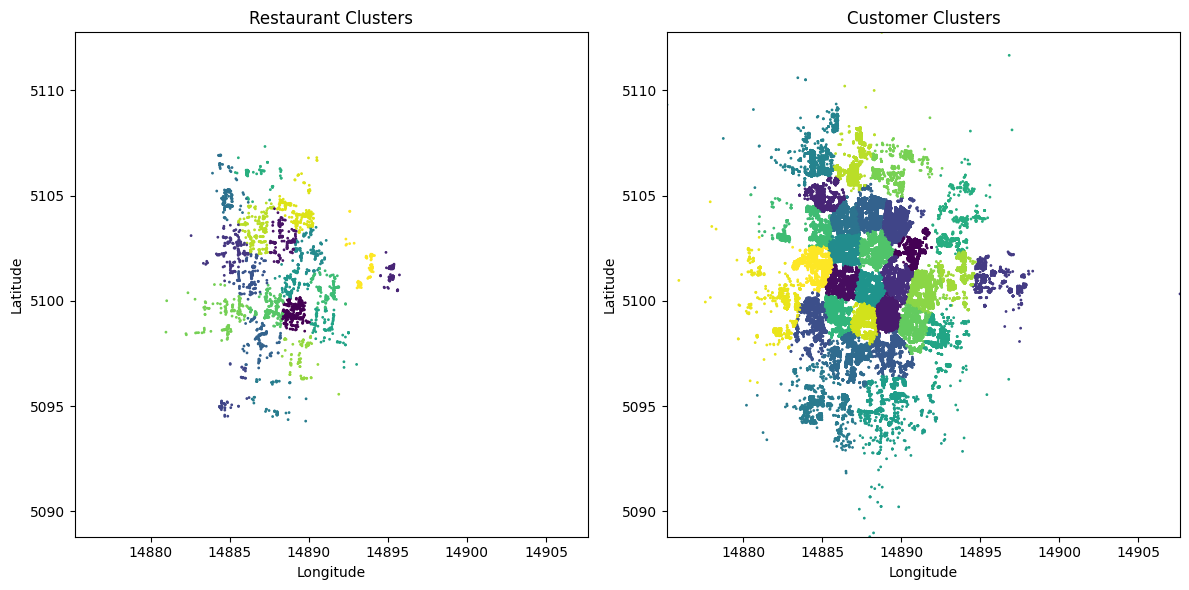

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(select_restaurants['sender_x'], select_restaurants['sender_y'], c=select_restaurants['sender_cluster'], s=1)
plt.title('Restaurant Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(min(min(select_customers['recipient_x']), min(select_restaurants['sender_x'])), max(max(select_customers['recipient_x']), max(select_restaurants['sender_x'])))
plt.ylim(min(min(select_customers['recipient_y']), min(select_restaurants['sender_y'])), max(max(select_customers['recipient_y']), max(select_restaurants['sender_y'])))

plt.subplot(1, 2, 2)
plt.scatter(select_customers['recipient_x'], select_customers['recipient_y'], c=select_customers['recipient_cluster'], s=1)
plt.title('Customer Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(min(min(select_customers['recipient_x']), min(select_restaurants['sender_x'])), max(max(select_customers['recipient_x']), max(select_restaurants['sender_x'])))
plt.ylim(min(min(select_customers['recipient_y']), min(select_restaurants['sender_y'])), max(max(select_customers['recipient_y']), max(select_restaurants['sender_y'])))

plt.tight_layout()
plt.show()

In [25]:
from scipy.spatial import ConvexHull

def calibrate_params(MAX_BATCH, BATCH_WINDOW, LAMBDA_CUTOFF = 0.1, BETA_BHH = 0.8943):

  # travel speed
  travel_speed = np.nanmean(courier_trajectory[(courier_trajectory['time'].dt.time >= start_time) &
    (courier_trajectory['time'].dt.time <= end_time) &
    (courier_trajectory['time_diff'] >= pd.Timedelta(minutes = 5)) &
    (courier_trajectory['time_diff'] <= pd.Timedelta(hours = total_hours)) &
    (courier_trajectory['courier_diff'] == 0) &
    (courier_trajectory['action'] == 'arrive')]['speed'])

  print('Travel speed:', travel_speed)

  # travel time
  area_restaurants = np.zeros(N_RESTAURANTS)
  area_customers = np.zeros(N_CUSTOMERS)

  for i in range(N_RESTAURANTS):
    area_restaurants[i] = ConvexHull(np.array(select_restaurants[select_restaurants['sender_cluster']==i][["sender_x", "sender_y"]])).area
  for j in range(N_CUSTOMERS):
    area_customers[j] = ConvexHull(np.array(select_customers[select_customers['recipient_cluster']==j][["recipient_x", "recipient_y"]])).area

  tau = np.zeros((N_RESTAURANTS, N_CUSTOMERS, MAX_BATCH))

  for i in range(N_RESTAURANTS):
    for j in range(N_CUSTOMERS):
      tau[i,j,0] = dist(clustering_restaurants.cluster_centers_[i,0], clustering_restaurants.cluster_centers_[i,1], clustering_customers.cluster_centers_[j,0], clustering_customers.cluster_centers_[j,1]) / travel_speed
      for b in range(2, MAX_BATCH+1):
        tau[i,j,b-1] = tau[i,j,0] + BETA_BHH * np.sqrt(b) * (np.sqrt(area_restaurants[i]) + np.sqrt(area_customers[j])) / travel_speed

  # arrival rate
  LAMBDA = np.zeros((N_RESTAURANTS, N_CUSTOMERS, MAX_BATCH))

  queue_size = np.zeros((N_RESTAURANTS, N_CUSTOMERS), dtype = np.int32)
  queue_time = np.zeros((N_RESTAURANTS, N_CUSTOMERS))

  for index, row in select_waybill.iterrows():
    i = row['sender_cluster']
    j = row['recipient_cluster']
    current_time = row['order_push_time_f'].day*24 + row['order_push_time_f'].hour + row['order_push_time_f'].minute / 60 + row['order_push_time_f'].second / 3600
    if (current_time - queue_time[i,j] > BATCH_WINDOW and queue_size[i,j] > 0) or (queue_size[i,j] == MAX_BATCH):
        LAMBDA[i,j, queue_size[i,j] - 1] += 1
        queue_size[i,j] = 0

    queue_size[i,j] += 1
    if (queue_size[i,j] == 1):
      queue_time[i,j] = current_time

  for i in range(N_RESTAURANTS):
    for j in range(N_CUSTOMERS):
      if (queue_size[i,j] > 0):
        LAMBDA[i,j, queue_size[i,j] - 1] += 1

      for b in range(MAX_BATCH):
        LAMBDA[i,j,b] /= (total_hours * total_days)
        if (LAMBDA[i,j,b] < LAMBDA_CUTOFF):
          LAMBDA[i,j,b] = 0

  # MU_P
  MU_P = 0

  for dt in all_waybill['dt'].unique():
    temp_waybill = all_waybill[(all_waybill['dt']==dt)&(all_waybill['is_prebook']==0)&(all_waybill['da_id'].isin(part_time_da_ids))]
    MU_P += len(set(temp_waybill[temp_waybill['order_push_time_f'].dt.time <= end_time]['courier_id']) - set(temp_waybill[temp_waybill['order_push_time_f'].dt.time < start_time]['courier_id']))

  MU_P /= (total_hours * total_days)

  print('MU_P:', MU_P)

  return tau, LAMBDA, MU_P

In [26]:
MAX_BATCH = 3
BATCH_WINDOW = 1/6 #(in hours)

tau, LAMBDA, MU_P = calibrate_params(MAX_BATCH, BATCH_WINDOW)

Travel speed: 10.197881752606866
MU_P: 471.85


In [41]:
w = 33.6
c = 3
beta = 0.9

R = 26.43 + 26.43 * beta + 26.43/2 * beta**2

results = solve_model(w, c, R, beta, N_RESTAURANTS, N_CUSTOMERS, tau, LAMBDA, MU_P, V_MAX = max(R, w / np.log(1/beta)), RELOCATION_K = 3, MAX_BATCH = MAX_BATCH)

Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
MIPGap  0.01
NonConvex  2

Academic license 2556960 - for non-commercial use only - registered to ju___@berkeley.edu
Optimize a model with 4002 rows, 4902 columns and 15200 nonzeros
Model fingerprint: 0x61c00032
Model has 141 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-01, 1e+00]
  QMatrix range    [7e-01, 1e+00]
  QLMatrix range   [2e-02, 6e+01]
  Objective range  [2e-01, 9e+01]
  Bounds range     [1e-01, 2e+05]
  RHS range        [2e-02, 5e+02]
Presolve removed 2273 rows and 2272 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 3191 rows and 3191 columns
Presolve time: 0.02s
Presolved: 9274 rows, 3770 column

In [42]:
print(np.sum(results['lam_f_rcb']), np.sum(results['lam_p_rcb']))

15.701175160374406 2729.9988248396257
